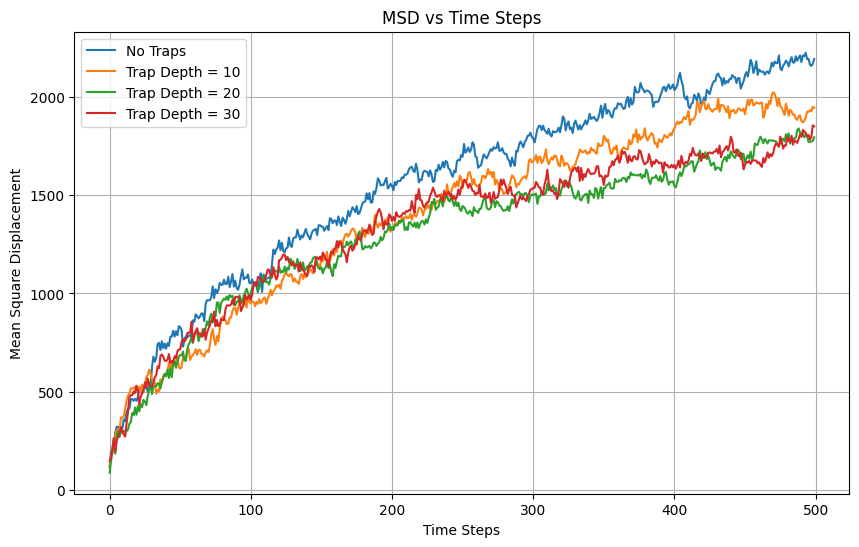

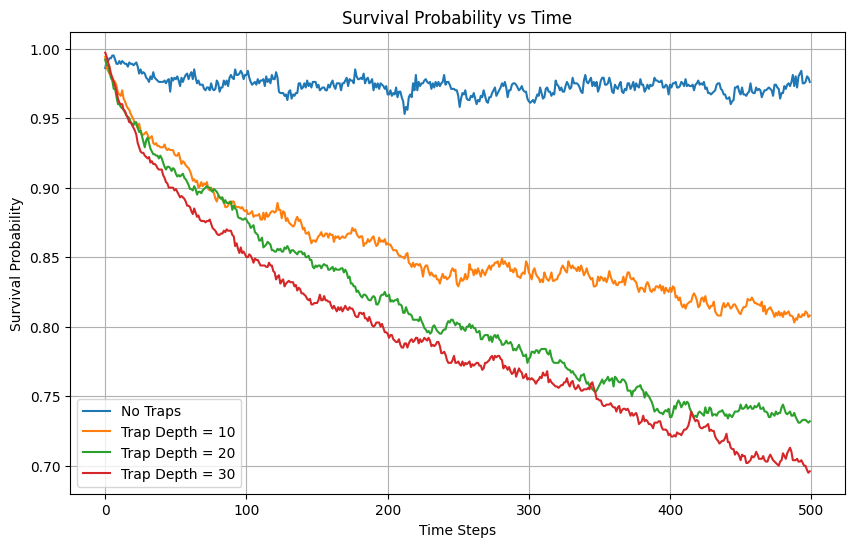

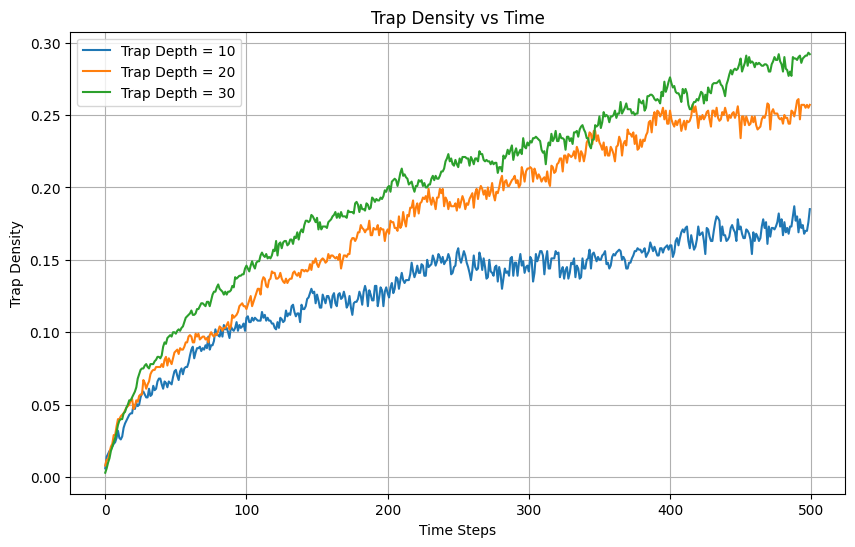

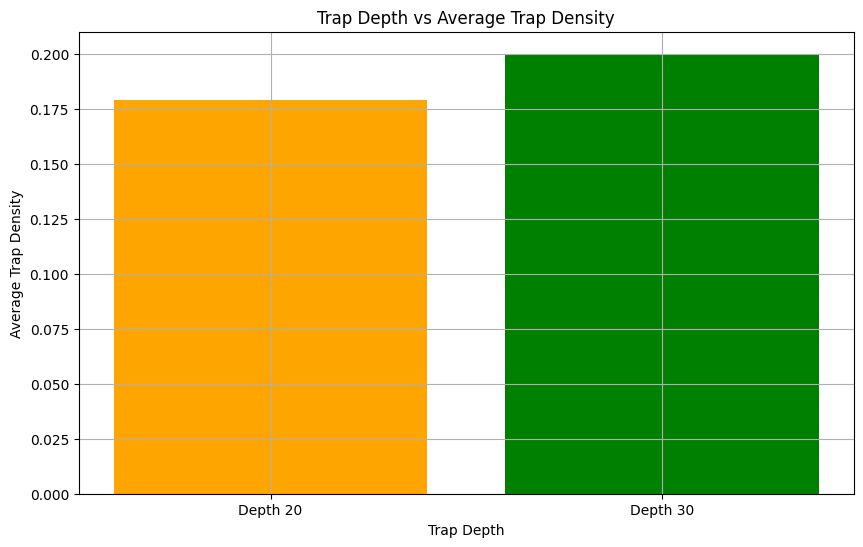

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 100  # Lattice size
N_particles = 1000  # Fixed number of particles
num_steps = 500  # Number of time steps
trap_size = 3  # Trap radius
delta_t = 1.0  # Time step size


trap_depths = [0, 10, 20, 30]  
N_traps = 10  

trap_depths_modified = [10, 20, 30, 40]

# Initialize traps
def initialize_traps(L, N_traps, trap_size):
    traps = []
    for _ in range(N_traps):
        while True:
            trap_center = np.random.randint(0, L, size=2)
            if all(np.linalg.norm(np.array(trap_center) - np.array(t)) > 2 * trap_size for t in traps):
                traps.append(trap_center)
                break
    return np.array(traps)

# Initialize particles
def initialize_particles(N_particles, L, traps, trap_size):
    positions = np.zeros((N_particles, 2), dtype=int)
    for i in range(N_particles):
        while True:
            pos = np.random.randint(0, L, size=2)
            if not any(np.linalg.norm(pos - trap) <= trap_size for trap in traps):
                positions[i] = pos
                break
    return positions

# Check if a particle is in a trap
def is_in_trap(position, traps, trap_size):
    for trap in traps:
        if np.linalg.norm(position - [trap.x,trap.y]) <= trap_size:
            return True
    return False

# Simulate diffusion
def simulate_diffusion(L, N_particles, traps, trap_size, trap_depth, num_steps):
    positions = initialize_particles(N_particles, L, traps, trap_size)
    trapping_times = np.zeros(N_particles)
    msd = np.zeros(num_steps)
    survival_prob = np.zeros(num_steps)
    trap_density = np.zeros(num_steps)

    initial_positions = positions.copy()

    for t in range(num_steps):
        free_particles = 0
        for i in range(N_particles):
            if trapping_times[i] > 0:
                trapping_times[i] -= delta_t
                continue

            move = np.random.choice(['up', 'down', 'left', 'right'])
            if move == 'up':
                positions[i][0] = (positions[i][0] + 1) % L
            elif move == 'down':
                positions[i][0] = (positions[i][0] - 1) % L
            elif move == 'right':
                positions[i][1] = (positions[i][1] + 1) % L
            elif move == 'left':
                positions[i][1] = (positions[i][1] - 1) % L

            if is_in_trap(positions[i], traps, trap_size):
                trapping_times[i] = trap_depth
            else:
                free_particles += 1

        displacement = positions - initial_positions
        msd[t] = np.mean(displacement[:, 0]**2 + displacement[:, 1]**2)
        survival_prob[t] = free_particles / N_particles
        trap_density[t] = np.sum(trapping_times > 0) / N_particles

    return msd, survival_prob, trap_density

# Main loop for different trap depths
msd_results = {}
survival_results = {}
trap_density_results = {}
traps = initialize_traps(L, N_traps, trap_size)

for i in range(len(trap_depths)):
    msd, survival_prob, trap_density = simulate_diffusion(L, N_particles, traps, trap_size, trap_depths[i], num_steps)
    msd_results[trap_depths[i]] = msd
    survival_results[depth] = survival_prob
    trap_density_results[depth] = trap_density


# MSD vs Time Plot
plt.figure(figsize=(10, 6))
for depth, msd in msd_results.items():
    label = f"Trap Depth = {depth}" if depth > 0 else "No Traps"
    plt.plot(msd, label=label)
plt.title("MSD vs Time Steps")
plt.xlabel("Time Steps")
plt.ylabel("Mean Square Displacement")
plt.legend()
plt.grid(True)
plt.show()

# Survival Probability vs Time Plot
plt.figure(figsize=(10, 6))
for depth, survival_prob in survival_results.items():
    label = f"Trap Depth = {depth}" if depth > 0 else "No Traps"
    plt.plot(survival_prob, label=label)
plt.title("Survival Probability vs Time")
plt.xlabel("Time Steps")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()

# Trap Density vs Time Plot
plt.figure(figsize=(10, 6))
for depth, trap_density in trap_density_results.items():
    if depth > 0:  # Exclude the no-trap case
        plt.plot(trap_density, label=f"Trap Depth = {depth}")
plt.title("Trap Density vs Time")
plt.xlabel("Time Steps")
plt.ylabel("Trap Density")
plt.legend()
plt.grid(True)
plt.show()


# Trap Depth vs Average Trap Density (Bar Chart)
avg_trap_densities = [np.mean(trap_density_results[depth]) for depth in trap_depths if depth > 0]
plt.figure(figsize=(10, 6))
plt.bar([f"Depth {d}" for d in trap_depths if d > 0], avg_trap_densities, color=['orange', 'green', 'purple'])
plt.title("Trap Depth vs Average Trap Density")
plt.xlabel("Trap Depth")
plt.ylabel("Average Trap Density")
plt.grid(True)
plt.show()


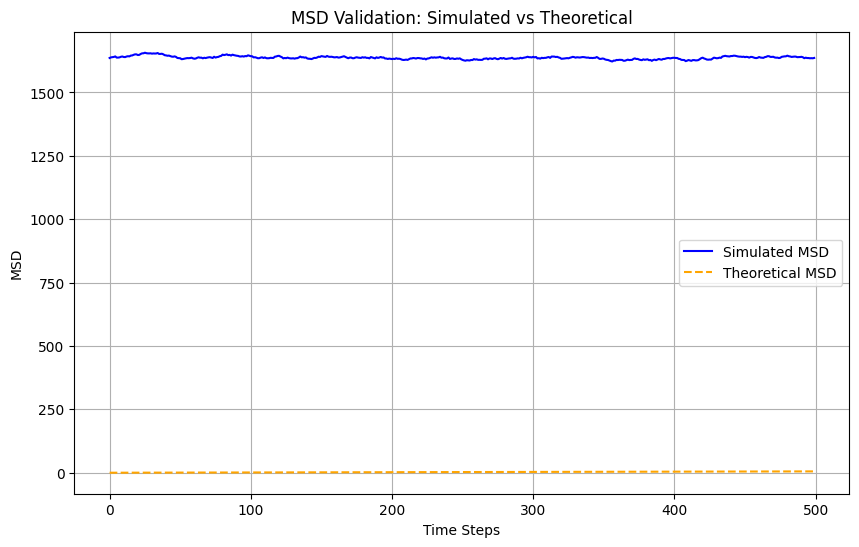

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 100  # Grid size
N_particles = 1000  # Number of particles
num_steps = 500  # Number of time steps
trap_radius = 3  # Trap radius
trap_depth = 10  # Trap depth influences trapping time
tau = 50  # Trapping time
t_0 = 10  # Characteristic feeding time
D = 1.0  # Diffusion coefficient
lambda_val = (4 * np.pi / 3) * trap_radius**3 * tau / t_0  # Lambda parameter

# Initialize particles and traps
def initialize_particles(N, L):
    """Initialize particle positions randomly."""
    return np.random.randint(0, L, size=(N, 2))

def initialize_traps(L, num_traps, radius):
    """Initialize traps randomly with a given radius."""
    traps = []
    for _ in range(num_traps):
        while True:
            center = np.random.randint(0, L, size=2)
            if all(np.linalg.norm(center - t) > radius for t in traps):
                traps.append(center)
                break
    return np.array(traps)

# Simulate Brownian motion with traps
def simulate_motion(N_particles, traps, L, radius, trap_depth, tau, num_steps):
    """Simulate particle motion with traps."""
    positions = initialize_particles(N_particles, L)
    trapped = np.zeros(N_particles, dtype=bool)
    trap_timer = np.zeros(N_particles)
    msd = np.zeros(num_steps)

    for t in range(num_steps):
        for i in range(N_particles):
            # If particle is trapped, decrement its trap timer
            if trapped[i]:
                trap_timer[i] -= 1
                if trap_timer[i] <= 0:
                    trapped[i] = False  # Release particle
                continue

            # Random walk for untrapped particles
            move = np.random.choice(['up', 'down', 'left', 'right'])
            if move == 'up':
                positions[i][0] = (positions[i][0] + 1) % L
            elif move == 'down':
                positions[i][0] = (positions[i][0] - 1) % L
            elif move == 'right':
                positions[i][1] = (positions[i][1] + 1) % L
            elif move == 'left':
                positions[i][1] = (positions[i][1] - 1) % L

            # Check if the particle falls into a trap
            for trap in traps:
                if np.linalg.norm(positions[i] - trap) <= radius:
                    trapped[i] = True
                    trap_timer[i] = tau
                    break

        # Compute Mean Squared Displacement
        msd[t] = np.mean(np.sum((positions - positions.mean(axis=0))**2, axis=1))

    return msd

# Initialize traps
traps = initialize_traps(L, 10, trap_radius)

# Simulate motion
simulated_msd = simulate_motion(N_particles, traps, L, trap_radius, trap_depth, tau, num_steps)

# Theoretical MSD
theoretical_msd = (6 * D * np.arange(num_steps)) / (lambda_val + 1)

# Plot Simulated MSD vs Theoretical MSD
plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_steps), simulated_msd, label="Simulated MSD", color='blue')
plt.plot(np.arange(num_steps), theoretical_msd, '--', label="Theoretical MSD", color='orange')
plt.title("MSD Validation: Simulated vs Theoretical")
plt.xlabel("Time Steps")
plt.ylabel("MSD")
plt.legend()
plt.grid()
plt.show()


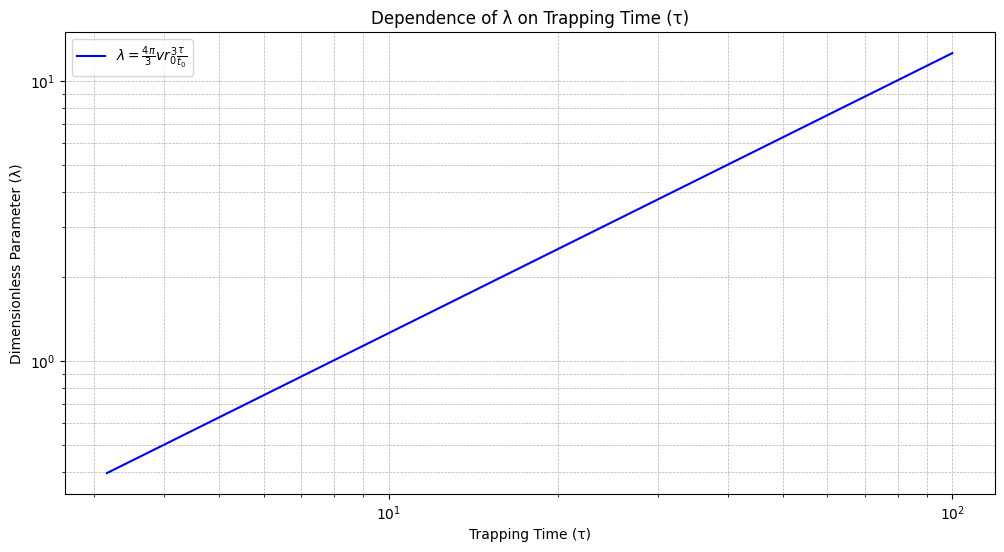

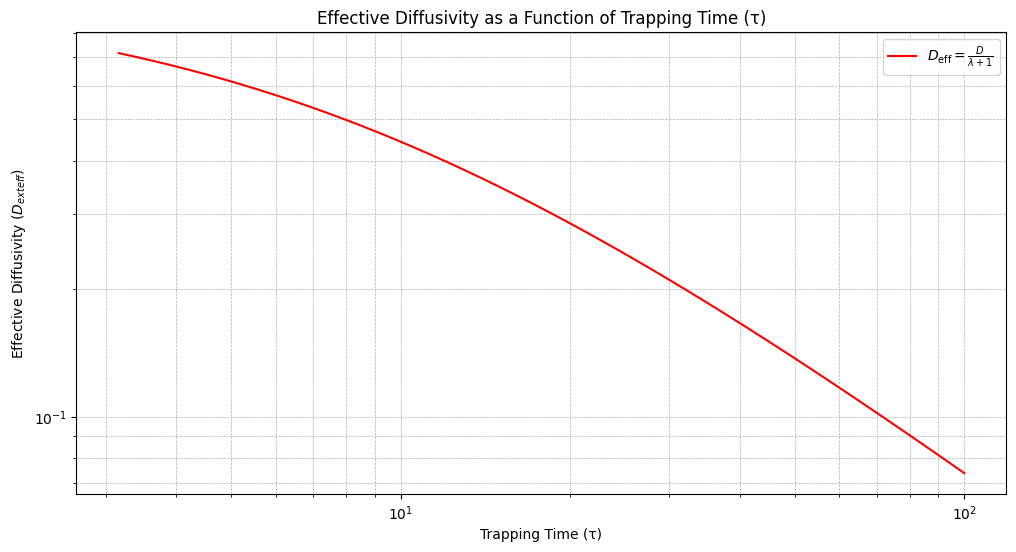

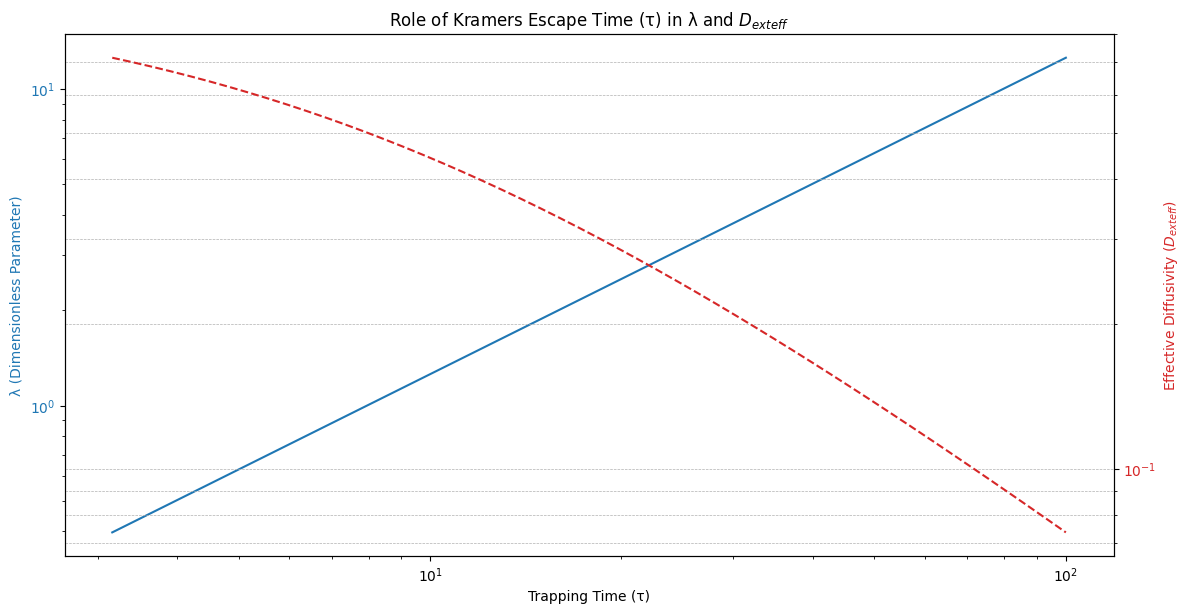

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and parameters
trap_radius = 3  # Radius of the traps
D = 1.0  # Diffusion constant
t_0 = trap_radius**2 / D  # Characteristic trapping time for feeding
trap_volume = (4 / 3) * np.pi * trap_radius**3  # Volume of a single trap
v = 0.01  # Density of traps (small fraction)

# Define a range of trapping times (τ) to explore the relationship
tau_values = np.logspace(0.5, 2.0, 50)  # Trapping times from 10^0.5 to 10^2
lambda_values = trap_volume * v * tau_values / t_0  # Compute λ for each τ
D_eff_values = D / (lambda_values + 1)  # Effective diffusivity for each λ

# Plot λ vs τ
plt.figure(figsize=(12, 6))
plt.plot(tau_values, lambda_values, label=r'$\lambda = \frac{4\pi}{3}vr_0^3 \frac{\tau}{t_0}$', color='b')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Trapping Time (τ)')
plt.ylabel('Dimensionless Parameter (λ)')
plt.title('Dependence of λ on Trapping Time (τ)')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Plot D_eff vs τ
plt.figure(figsize=(12, 6))
plt.plot(tau_values, D_eff_values, label=r'$D_{\text{eff}} = \frac{D}{\lambda + 1}$', color='r')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Trapping Time (τ)')
plt.ylabel('Effective Diffusivity ($D_{\text{eff}}$)')
plt.title('Effective Diffusivity as a Function of Trapping Time (τ)')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# Overlay: λ vs τ and D_eff vs τ
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Trapping Time (τ)')
ax1.set_ylabel('λ (Dimensionless Parameter)', color=color)
ax1.plot(tau_values, lambda_values, color=color, label=r'$\lambda$')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.set_yscale('log')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Effective Diffusivity ($D_{\text{eff}}$)', color=color)
ax2.plot(tau_values, D_eff_values, color=color, linestyle='--', label=r'$D_{\text{eff}}$')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Role of Kramers Escape Time (τ) in λ and $D_{\text{eff}}$')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()
